# 1.3 Grouping Data
Plotting each column with the date of each observation is useful to understand the historic behavior and to observe multiyear trends, but as you may noticed, most variable have strong seasonal (yearly) component. 
The function `plot_contents()` can be use to get insights into the yearly variation.

In [1]:
from funciones import*
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep="\t")
#Data=pd.read_csv('https://raw.githubusercontent.com/iceclassic/sandbox/main/Data/Time_series_DATA.txt',index_col=0,skiprows=149)
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Data = Data[Data.index.year < 2022]

:::{card} Exercise 1
Read the documentation for `plot_contents()` plot the yearly variation of the columns `'Regional: Air temperature [C]'`and `'Gulkana Temperature [C]'`
:::

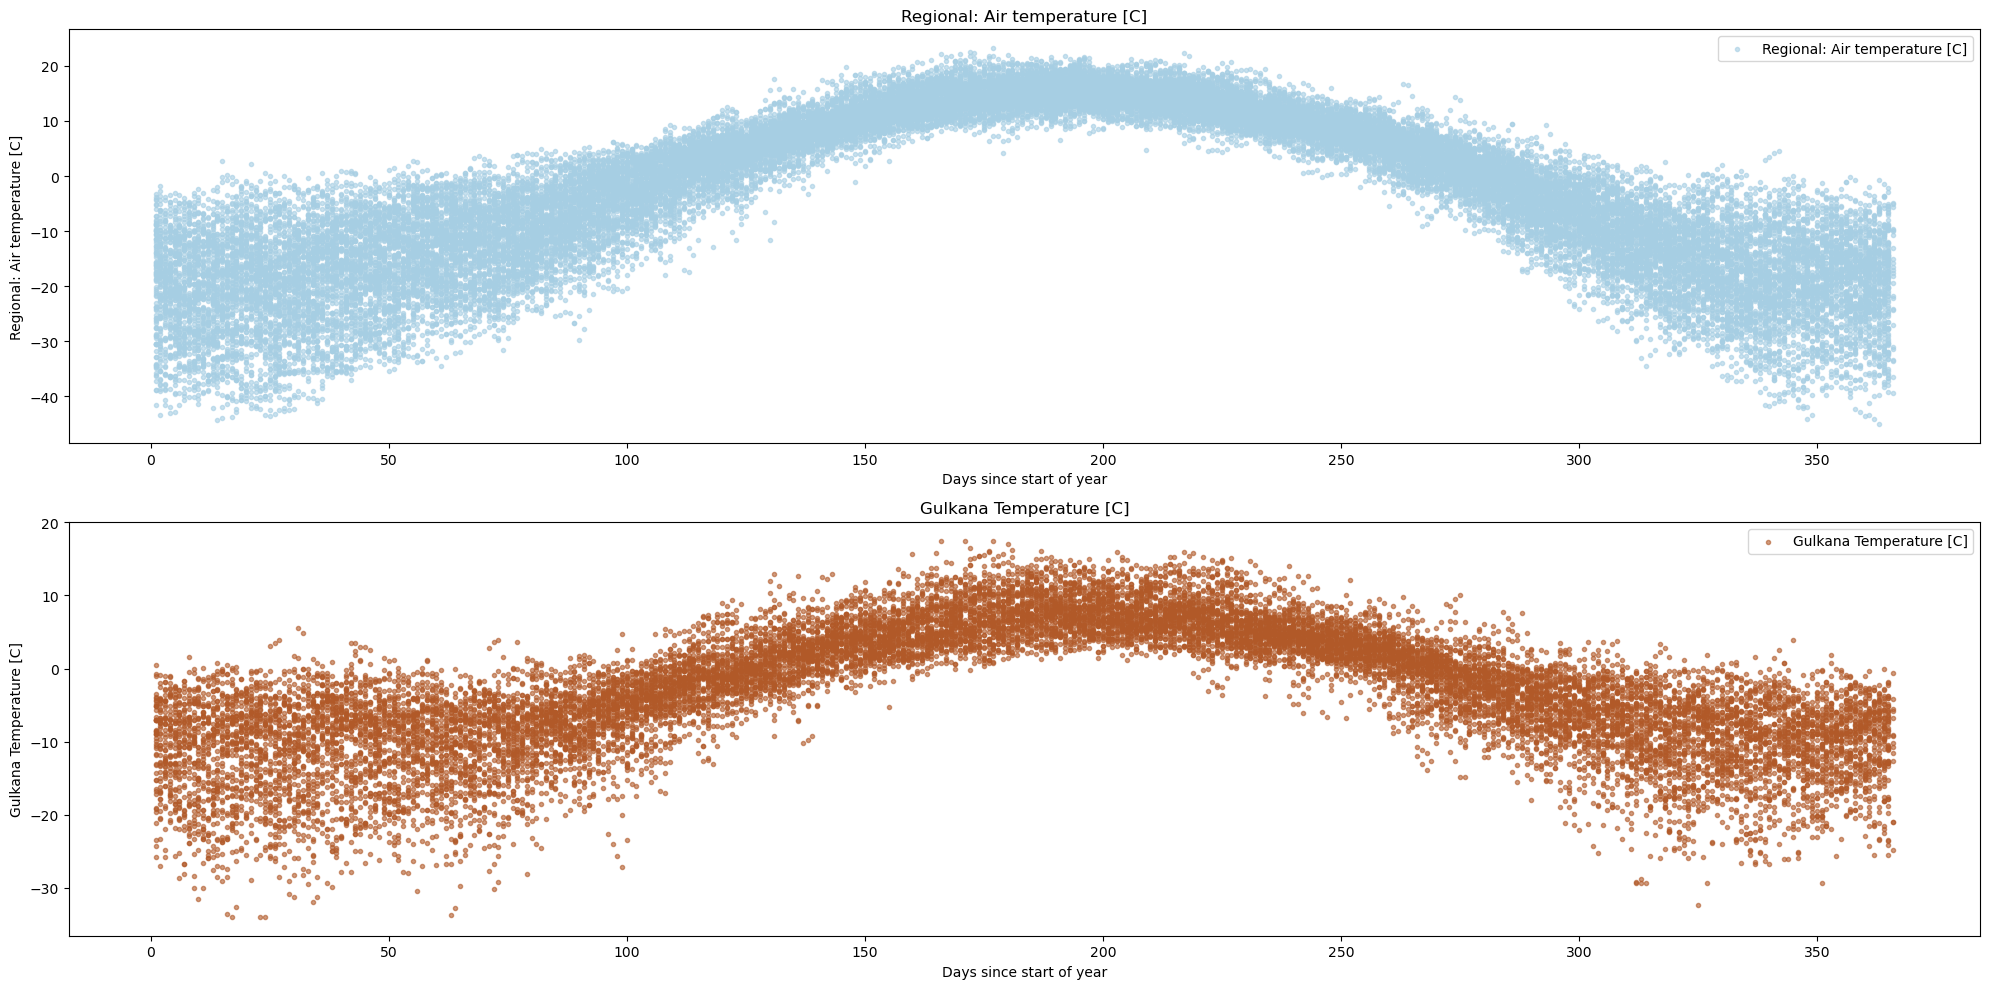

In [2]:
plot_contents(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],col_cmap='Paired',scatter_alpha=0.6)

Instead of plotting all the operation, plotting just  the mean and the standard deviation could be more useful.

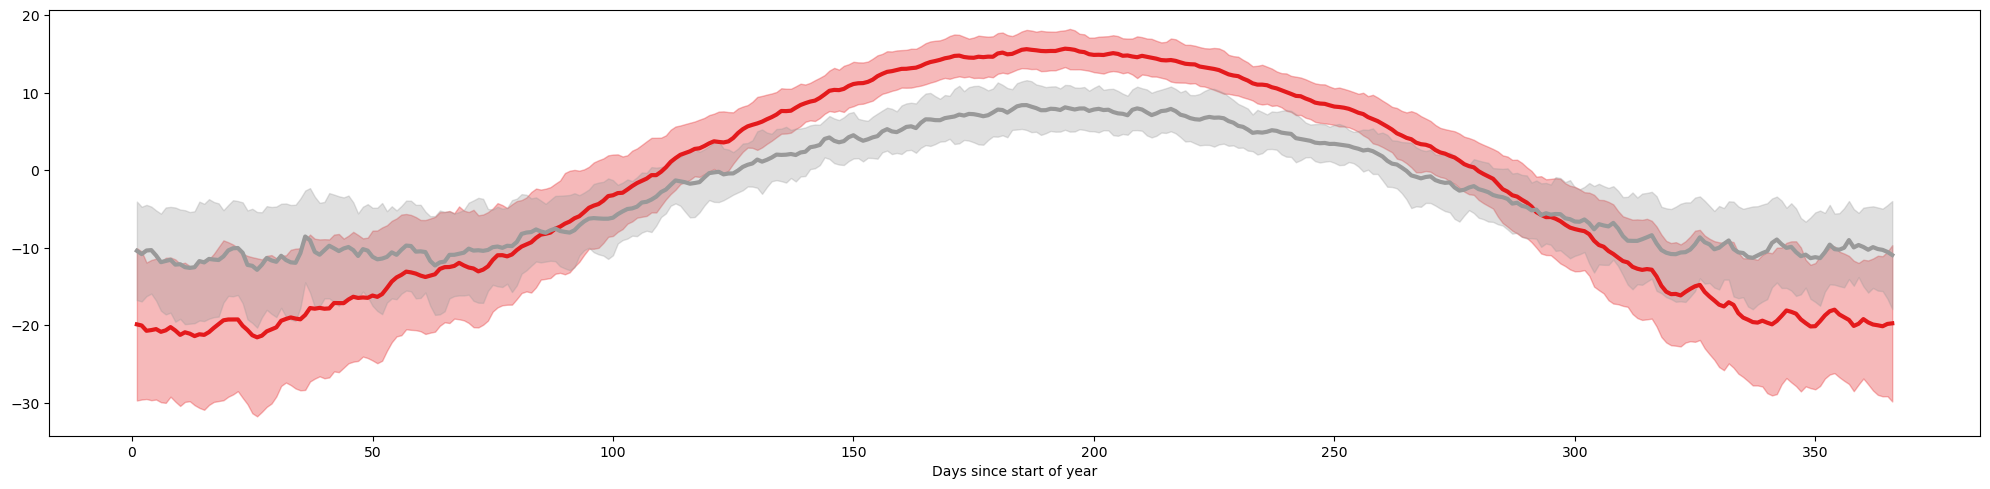

In [3]:
plot_contents(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],plot_together=True,plot_mean_std='only',k=1)

:::{card} Exercise 3

Use  the argument  `multiyear`  to plot the data corresponding to the years 2009 and 2015 over the mean.

:::

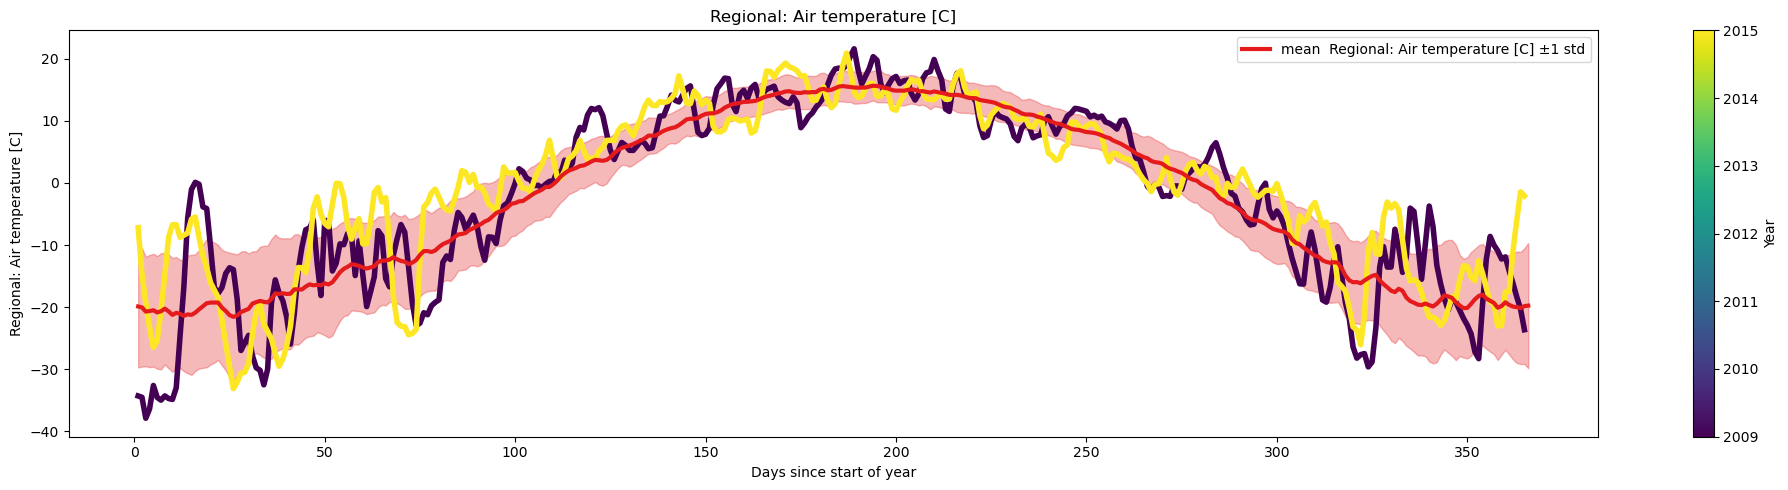

In [4]:
selected_years = [2009,2015]
plot_contents(Data,k=1,plot_mean_std='only',multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'])

Using the number of days since the start of the year, is a natural yet completely arbitration choice, there is nothing special about january first or december 31. More likely another date or event/milestone is more meaningful, for example, choosing `xaxis='Days until break-up'` might be useful to  observe trends leading up to the ice break-up, or , choosing `xaxis='index'` will recover the timeseries plot.

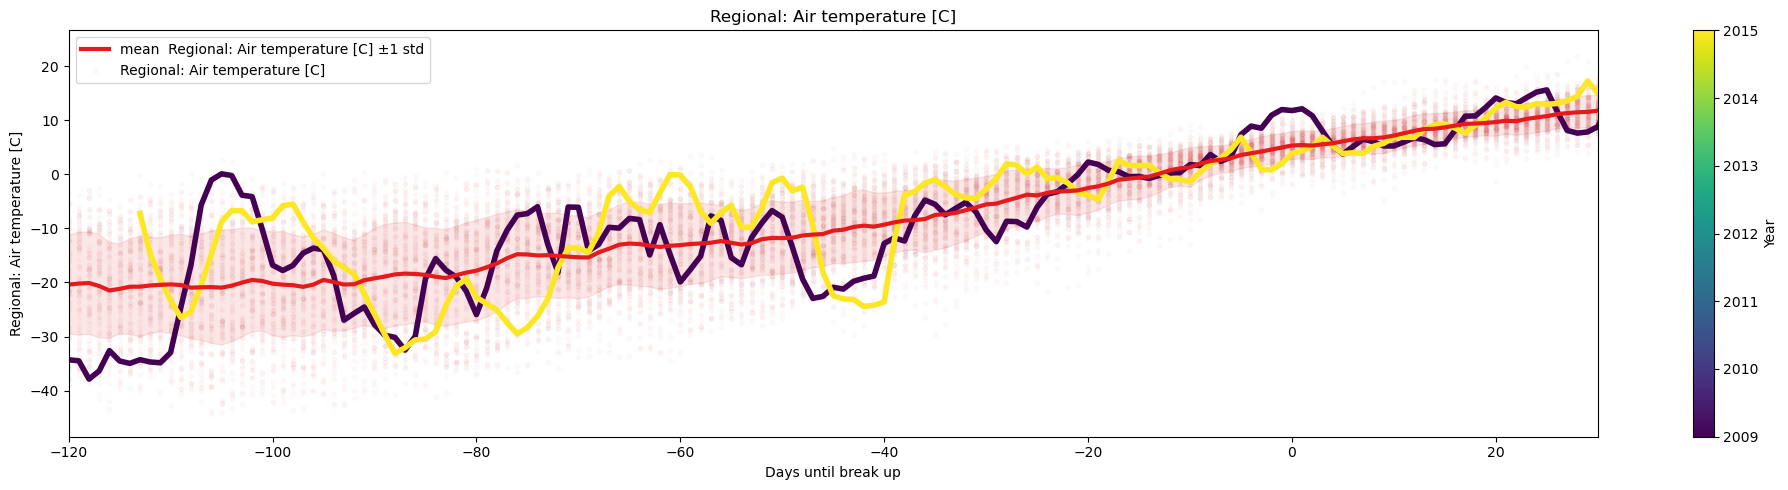

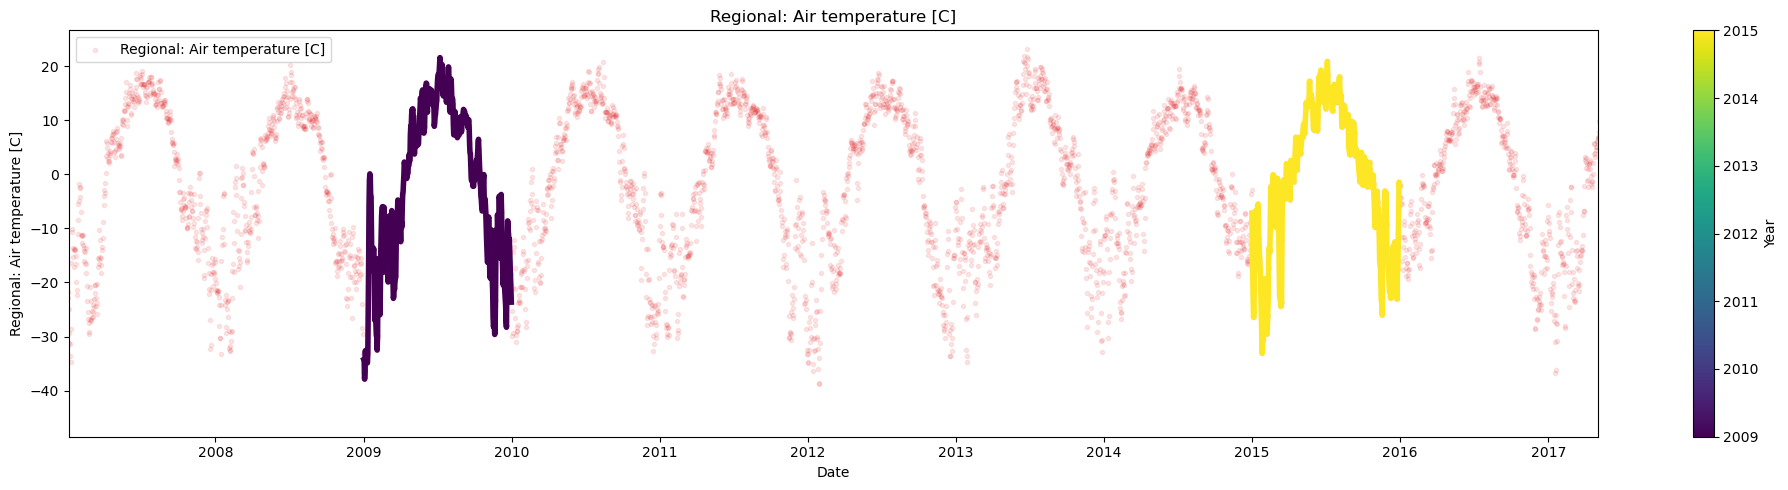

In [5]:
plot_contents(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Days until break up',xlim=[-120,30],
              plot_mean_std='true',scatter_alpha=.02,std_alpha=.1) 

plot_contents(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='index',xlim=['2007/01/04','2017/05/03']) 

If we wanted to use another grouping or 'x-axis' we would need to create a new DataFrame/Series, merge it to the original DataFrame and then use the previous function.

:::{card} Exercise 2
Use `days_since_last_date()` and `plot_contents()` to plot the temperature variation since the start of winter.
:::

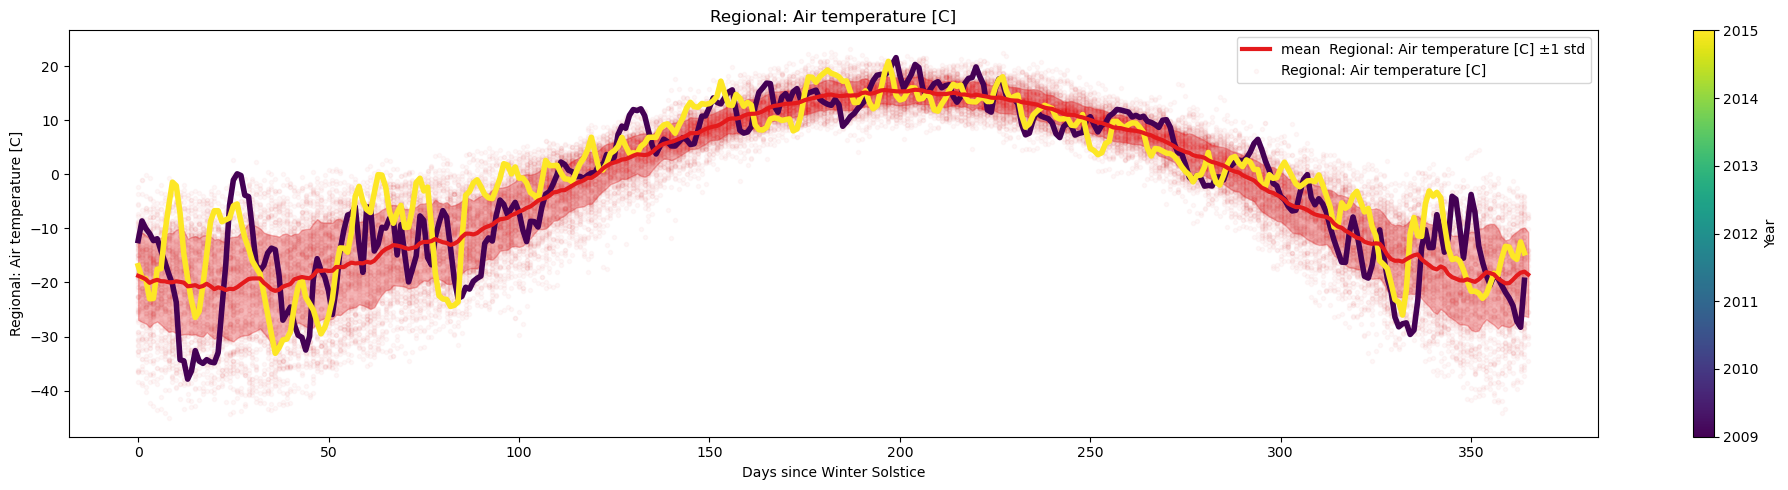

In [6]:
Data_2=days_since_last_date(Data,date='12/21',name='Winter Solstice')
plot_contents(Data_2,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Winter Solstice',xaxis_name='Days since Winter Solstice',scatter_alpha=0.03,multiyear=selected_years)

## `groupby` and `transform`

We have grouped the variables using the number of days since the last occurrence od a date ('MM/DD'). For more complex groupings it is easier to use `groupby` and `transform`. 

For example, lets try to re-create the plot above but considering the number of days since the river began to freeze which is different for each year.

:::{card}
We define that the river has began to freeze the lates occasion since in each year since the mean daily temperature was below zero for three consecutive days after it was above 0.

**Naive Approach**

A simple approach would be to loop through each year and day checking if the river has started to freeze.

Use two nested `for` loops to create a list with the dates that the Nenana river started to freeze. 
Use the [`time`](https://docs.python.org/3/library/time.html#functions) module to compute the time needed to execute the operation.
:::




In [7]:
t1_0 = time.time()
years = Data.index.year.unique()
freezing_dates_1 = [None] * len(years)  

for year_index, year in enumerate(years):  # Looping through years 
    df_year = Data[Data.index.year == year].copy()  # Extracting data for that year
    df_year['Rolling Mean'] = df_year['Regional: Air temperature [C]'].rolling(window=3).mean()  # Compute rolling mean

    Frozen = False  # Initial state

    for i in range(3, len(df_year)):  # Looping through days of that year, starting from day 3 since we are using a rolling mean of 3
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']  
        T_rolling_mean = df_year.at[df_year.index[i], 'Rolling Mean']  
        T_rolling_mean_prev = df_year.at[df_year.index[i - 1], 'Rolling Mean']  
        
        if T_rolling_mean < 0 and T_rolling_mean_prev >= 0:  # Condition for freezing
            Frozen = True
            freezing_dates_1[year_index] = df_year.index[i].strftime('%Y/%m/%d')  

t1_f = time.time()  # Record the end time
delta_t1 = t1_f - t1_0
print(f"Elapsed time: {delta_t1:.4f} seconds")

Elapsed time: 3.3006 seconds


**Vector approach**

Just like in `numpy`, the performance can be greatly improve by vectorizing  the code.
The method [`.groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) is used to *split* the dataframe into a group based on some criteria, then the method [`.transform()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html) can be use to *apply* a functions to the group.

Depending on the charactesitics of the `DataFrame`/`Series` and the operation that you want to apply to it,  other similar method such as `.filter()`, `. apply()`, `.agg()` or `.map()` might be more suitable (see [user guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)), 



In [8]:
t2_0 = time.time()
rolling_avg_below_zero = Data['Regional: Air temperature [C]'].rolling(window=3).mean().lt(0) # rolling mean '.ls'= less than and returns boolean
freezing_dates_2 = (
    rolling_avg_below_zero.groupby(Data.index.year)                                            # Group by year
    .apply(lambda x: x.index[x & ~x.shift(1, fill_value=False)].max())                         # logic to find the date and then keep the max date of each group(year)                       
    .dropna()                                                                                  # To avoid errors  in next line when the condition is not met
    .apply(lambda date: date.strftime('%Y/%m/%d'))                                             # Convert to string every element                                   
    .tolist()                                                                                  # Convert to list       
)
t2_f = time.time()  # Record the end time
delta_t2 = t2_f - t2_0
print(f"Elapsed time: {delta_t2:.4f} seconds")

Elapsed time: 0.0851 seconds


In the code above we did not use a function, instead we used a [`lambda`](https://docs.python.org/3/reference/expressions.html#grammar-token-python-grammar-lambda_expr) expression. Lambda expression are temporary and anonymous functions that allows us to evaluate a logical expression in a single line, without necessary defining the function . 

The vector approach is generally faster and more flexible as  multiple methods and expressions  can be efficiently apply to each group. However, it can be a little difficult to understand if you are not familiar with it, lets break it down into five steps:

1. We create a `Series` with the freezing condition.  
    - `.rolling(window=3)` groups the data corresponding to three consecutive element. Because our index are dates, we are grouping the date of three consecutive days
    - `.mean()` computes the mean of the grouped data
    - `.lt(0)`  decide if the mean of the grouped is  less than (lt) 0. This logical expression output a boolean 
2. Grouping the data
    - `.groupby(Data.index.year)` groups the element of the `Series` according to the year in Data
    - `.index.year` extracts the year attribute of the datetime index to use the year of each row to group the data
3. Identifies when the freezing condition changes
    - `apply(lambda x: )`:  defines that we will use a `lambda` expression with `x`the variable
    - `x & ~x.shift(1, fill_value=False)`  Use the logical operator AND (`&`) to compare the variable with the  negated (`~`) shifted variable. 
    - `x.shift(1, fill_value=False)`shift the variable by one position, and assigning `False` to the first position.
4. Identifies the latest instance of change of freezing condition in each year 
    - `x.index[]` get the date associated with the change of freezing conditions
    - `.max()` get the latest date in each year ( maximum value of the index in the group (the data is grouped by year))

5. Post Processing
    - `.dropna()` drop the empty values which correspond to years where the freezing condition never happened (in this parituclar case it correspond to year without  temperature data)
    -  `.apply(lambda date: date.strftime('%Y/%m/%d'))` format the datetime object to a string
    - `.tolist()` convert the `Series` to a list

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '1917/10/15', '1918/10/14', '1919/10/29', '1920/10/02', '1921/10/13', '1922/10/19', '1923/10/31', '1924/10/07', '1925/10/23', '1926/10/25', '1927/10/05', '1928/11/06', '1929/10/13', '1930/10/11', '1931/10/10', '1932/10/14', '1933/10/04', '1934/12/10', '1935/11/06', '1936/10/28', '1937/10/18', '1938/10/28', '1939/10/05', '1940/10/30', '1941/10/09', '1942/10/07', '1943/10/20', '1944/10/22', '1945/10/08', '1946/10/19', '1947/10/10', '1948/10/06', '1949/10/05', '1950/10/10', '1951/11/04', '1952/10/18', '1953/10/17', '1954/11/04', '1955/10/08', '1956/09/22', '1957/10/25', '1958/10/04', '1959/10/07', '1960/10/07', '1961/10/23', '1962/10/18', '1963/10/10', '1964/10/15', '1965/09/30', '1966/10/09', '1967/10/06', '1968/10/05', '1969/10/20', '1970/11/03', '1971/10/19', '1972/10/20', '1973/10/06', '1974/09/30', '1975/10/08', '1976/11/15', '1977/10/13', '1978/10/11', '1979/11/13', '1980/10/27', '1981/1

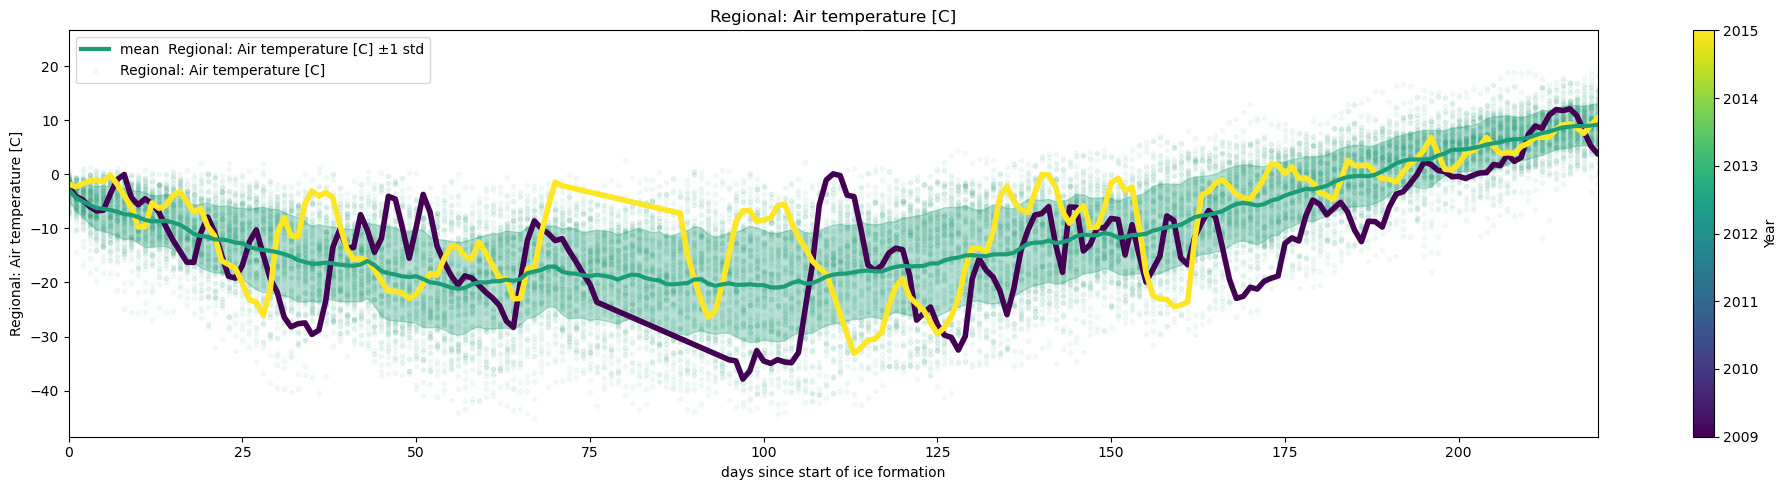

In [9]:
print(freezing_dates_1)
print(freezing_dates_2)
Data=days_since_last_date(Data,date=freezing_dates_2,name='days since start of ice formation')
plot_contents(Data,plot_mean_std=True,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],
              xaxis='days since start of ice formation',scatter_alpha=0.05,col_cmap='Dark2',k=1,xlim=[0,220])

:::{card} Ex NN

Use `groupby()` and `transform()` to add to the dataframe  columns with the accumulated number of days that the temperature has been over -2 degree, and the cumulative sum of the difference between the temperature and -2 [C], ignoring the days that had negative temperature (i.e only days where the mean temperature as positive ( use masks(), clip() or use just logic))

:::

In [10]:
Data['days_over_one'] = Data.groupby(Data.index.year)['Regional: Air temperature [C]'].transform(lambda x: (x > -2).cumsum()) # assumes that the number of day over 1 since the start of ice formation to jan 01 is zero 
Data['cumsum_pos_temp'] = Data.groupby(Data.index.year)['Regional: Air temperature [C]'].transform(lambda x: x.clip(lower=0).where(x > -2).cumsum())